In [22]:
using GraphRecipes, Plots;
using Graphs;
using LinearAlgebra;
using StatsBase;
using Dates;
using Cairo;

minimumby(f, iter) = reduce(iter) do x, y
    f(x) < f(y) ? x : y
end
minimum_idx_by(f, iter) = reduce(1:length(iter)) do x, y
    f(iter[x]) < f(iter[y]) ? x : y
end

minimum_idx_by (generic function with 1 method)

In [2]:
D = [
        0 2451 713 1018 1631 1374 2408 213 2571 875 1420 2145 1972;
        2451 0 1745 1524 831 1240 959 2596 403 1589 1374 357 579;
        713 1745 0 355 920 803 1737 851 1858 262 940 1453 1260;
        1018 1524 355 0 700 862 1395 1123 1584 466 1056 1280 987;
        1631 831 920 700 0 663 1021 1769 949 796 879 586 371;
        1374 1240 803 862 663 0 1681 1551 1765 547 225 887 999;
        2408 959 1737 1395 1021 1681 0 2493 678 1724 1891 1114 701;
        213 2596 851 1123 1769 1551 2493 0 2699 1038 1605 2300 2099;
        2571 403 1858 1584 949 1765 678 2699 0 1744 1645 653 600;
        875 1589 262 466 796 547 1724 1038 1744 0 679 1272 1162;
        1420 1374 940 1056 879 225 1891 1605 1645 679 0 1017 1200;
        2145 357 1453 1280 586 887 1114 2300 653 1272 1017 0 504;
        1972 579 1260 987 371 999 701 2099 600 1162 1200 504 0
    ]
println(size(D)[1])

13


In [60]:
function solve_salesman_ants(G, initial_vertex; ants_count=nothing, max_iter=100, alpha=1,beta=5,Q=100,pheromon_coef=0.9, initial_pheromon_amount=1e-6,
    verbose_every=1, log_every=1)
    VERTEX_COUNT = size(G)[1]
    if ants_count == nothing
        ants_count = VERTEX_COUNT
    end
    pheromon = fill(initial_pheromon_amount, size(G))
    iterations = 0
    history = [(pheromon, [1])]
    start = now()
    for epoch_idx in 1:max_iter
        iterations += 1
        ants_path = [[initial_vertex] for _ in 1:ants_count]
        C = [Set(ants_path[idx][1]) for idx in 1:ants_count]
        for q in 1:VERTEX_COUNT-1
            for ant_idx in 1:ants_count
                current_vertex = ants_path[ant_idx][end]
                denom = sum(cat(pheromon[current_vertex, 1:ant_idx-1], pheromon[current_vertex, ant_idx+1:end], dims=1) / cat(G[current_vertex, 1:ant_idx-1],G[current_vertex, ant_idx+1:end], dims=1))
                probs = []
                for vertex_idx in 1:VERTEX_COUNT
                    if !in(vertex_idx, C[ant_idx])
                        nomin = (pheromon[current_vertex, vertex_idx] ^ alpha)/(G[current_vertex, vertex_idx] ^ beta)
                        push!(probs, (vertex_idx, nomin / denom))
                    end
                end
                next_vertex = sample(first.(probs), Weights(last.(probs)))
                push!(ants_path[ant_idx], next_vertex)
                push!(C[ant_idx], next_vertex)
            end
        end
        L = zeros(ants_count)
        for ant_idx in eachindex(ants_path)
            for path_idx in 1:length(ants_path[ant_idx])-1
                L[ant_idx] += G[ants_path[ant_idx][path_idx], ants_path[ant_idx][path_idx+1]]
            end
        end
        for first_vertex_idx in 1:VERTEX_COUNT, second_vertex_idx in 1:VERTEX_COUNT
            delta = 0.0
            for ant_idx in 1:ants_count
                idx = findfirst(x->x==first_vertex_idx, ants_path[ant_idx])
                if idx != nothing && idx < length(ants_path[ant_idx]) && ants_path[ant_idx][idx+1] == second_vertex_idx
                    delta += Q/L[ant_idx]
                end
            end
            pheromon[first_vertex_idx, second_vertex_idx] = (1 - pheromon_coef) * pheromon[first_vertex_idx, second_vertex_idx] + delta
        end
        if log_every > 0 && epoch_idx % log_every == 0
            hist_path = [initial_vertex]
            hist_vertex = initial_vertex
            for idx in 1:VERTEX_COUNT-1
                hist_vertex = findmax(pheromon[hist_vertex,:])[2]
                push!(hist_path, hist_vertex)
            end
            push!(history, (copy(pheromon), hist_path))
        end
        if verbose_every > 0 && epoch_idx % verbose_every == 0
            current = now()
            println("epoch: $epoch_idx, elapsed: $(current - start)")
            flush(stdout)
            start = current
        end
    end
    best_path = [initial_vertex]
    best_vertex = initial_vertex
    for idx in 1:VERTEX_COUNT-1
        best_vertex = findmax(pheromon[best_vertex,:])[2]
        push!(best_path, best_vertex)
    end
    return pheromon, iterations, best_path, history
end
function DLOLinspace(x; src=(1000,10000), dest=(0,1))
    min_src, max_src = min(src...), max(src...)
    src_len = max_src - min_src
    min_dest, max_dest = min(dest...), max(dest...)
    dest_len = max_dest - min_dest
    return dest_len/(src_len + 1e-6) * (x - min_src) + min_dest
end

function transform_pheromon_to_alpha(pheromon)
    VERTEX_COUNT = size(pheromon)[1]
    result = fill(0.0, size(pheromon))
    for idx in 1:VERTEX_COUNT
        min_fit, max_fit = findmin(pheromon[idx,:])[1], findmax(pheromon[idx,:])[1]
        result[idx, :] = DLOLinspace.(pheromon[idx,:], src=(min_fit, max_fit))
    end
    return result
end

transform_pheromon_to_alpha (generic function with 1 method)

In [61]:
result, iterations, path, history = solve_salesman_ants(D, 1)

epoch: 1, elapsed: 1 millisecond
epoch: 2, elapsed: 2 milliseconds
epoch: 3, elapsed: 2 milliseconds
epoch: 4, elapsed: 1 millisecond
epoch: 5, elapsed: 2 milliseconds
epoch: 6, elapsed: 2 milliseconds
epoch: 7, elapsed: 2 milliseconds
epoch: 8, elapsed: 2 milliseconds
epoch: 9, elapsed: 16 milliseconds
epoch: 10, elapsed: 2 milliseconds
epoch: 11, elapsed: 3 milliseconds
epoch: 12, elapsed: 2 milliseconds
epoch: 13, elapsed: 2 milliseconds
epoch: 14, elapsed: 2 milliseconds
epoch: 15, elapsed: 3 milliseconds
epoch: 16, elapsed: 2 milliseconds
epoch: 17, elapsed: 3 milliseconds
epoch: 18, elapsed: 2 milliseconds
epoch: 19, elapsed: 1 millisecond
epoch: 20, elapsed: 2 milliseconds
epoch: 21, elapsed: 2 milliseconds
epoch: 22, elapsed: 2 milliseconds
epoch: 23, elapsed: 2 milliseconds
epoch: 24, elapsed: 2 milliseconds
epoch: 25, elapsed: 2 milliseconds
epoch: 26, elapsed: 2 milliseconds
epoch: 27, elapsed: 2 milliseconds
epoch: 28, elapsed: 3 milliseconds
epoch: 29, elapsed: 2 milliseco

([9.999999999999783e-107 9.999999999999783e-107 … 9.999999999999783e-107 9.999999999999783e-107; 9.999999999999783e-107 9.999999999999783e-107 … 3.259478926017906e-100 9.999999999999783e-107; … ; 9.999999999999783e-107 0.21523535157866844 … 9.999999999999783e-107 1.5581346547017861e-100; 9.999999999999783e-107 9.999999999999783e-107 … 0.21523535157866844 9.999999999999783e-107], 100, [1, 8, 3, 10, 4, 5, 13, 12, 2, 9, 7, 6, 11], [([9.999999999999783e-107 9.999999999999783e-107 … 9.999999999999783e-107 9.999999999999783e-107; 9.999999999999783e-107 9.999999999999783e-107 … 3.259478926017906e-100 9.999999999999783e-107; … ; 9.999999999999783e-107 0.21523535157866844 … 9.999999999999783e-107 1.5581346547017861e-100; 9.999999999999783e-107 9.999999999999783e-107 … 0.21523535157866844 9.999999999999783e-107], [1]), ([9.999999999999997e-8 9.999999999999997e-8 … 9.999999999999997e-8 9.999999999999997e-8; 9.999999999999997e-8 9.999999999999997e-8 … 0.04449722585910625 9.999999999999997e-8; … ; 

[ Info: Saved animation to /home/user/code/BMSTU/Optimizers/lab11/ants.gif


Plots.AnimatedGif("/home/user/code/BMSTU/Optimizers/lab11/ants.gif")
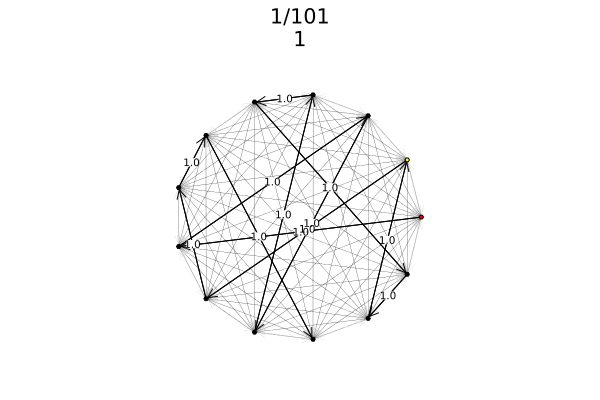

In [63]:
n = size(D)[1]
g = complete_digraph(n)
coords = [(cos((2*pi*idx)/n), sin((2*pi*idx)/n)) for idx in 0:n-1]
anim = @animate for idx in 1:length(history)
    alpha = transform_pheromon_to_alpha(history[idx][1])
    path = join(history[idx][2], "->")
    conj(s,d,w) = alpha[s, d]
    graphplot(g, x = first.(coords), y = last.(coords), edgelabel=round.(alpha, digits=2), curves=false, edgewidth=conj, markercolor = range(colorant"red", stop=colorant"yellow", length=2), title="$idx/$(length(history))\n$path")
end
gif(anim, "ants.gif", fps=2)